In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [3]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    train_size=int(0.75*len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    # data_loader_val = td.DataLoader(val,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [ ]:
data_loader_train,data_loader_test=load_data(r"/content/gdrive/MyDrive/Colab Notebooks/images",32,64)

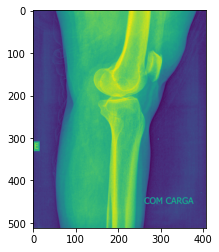

In [ ]:
img2=image.imread(r"/content/gdrive/MyDrive/Colab Notebooks/images/train/1.2.826.0.1.3680043.8.498.10299385524344582994601970314833752000-c.png")
plt.imshow(img2)

In [ ]:
import torch.optim as optim
from torchvision.models import resnet50
net=resnet50(weights=None)
resnet50(pretrained=False) 
# net = resNet50(22).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
###### Define and run your training loop here #########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
net.to(device)

num_epochs = 5
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        # print("kjnfjnrnkrn",i)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("second time",i)
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cpu
Epoch [1/5], Step [10/59], Loss: 2.3850, Accuracy: 78.12%
Epoch [1/5], Step [20/59], Loss: 1.2241, Accuracy: 59.38%
Epoch [1/5], Step [30/59], Loss: 1.8839, Accuracy: 50.00%
Epoch [1/5], Step [40/59], Loss: 2.2764, Accuracy: 75.00%
Epoch [1/5], Step [50/59], Loss: 3.0181, Accuracy: 68.75%
Epoch [2/5], Step [10/59], Loss: 1.2731, Accuracy: 21.88%
Epoch [2/5], Step [20/59], Loss: 0.8800, Accuracy: 84.38%
Epoch [2/5], Step [30/59], Loss: 1.2895, Accuracy: 59.38%
Epoch [2/5], Step [40/59], Loss: 1.1206, Accuracy: 65.62%
Epoch [2/5], Step [50/59], Loss: 0.8618, Accuracy: 81.25%
Epoch [3/5], Step [10/59], Loss: 1.0854, Accuracy: 71.88%
Epoch [3/5], Step [20/59], Loss: 1.1108, Accuracy: 68.75%
Epoch [3/5], Step [30/59], Loss: 1.1042, Accuracy: 71.88%
Epoch [3/5], Step [40/59], Loss: 1.0185, Accuracy: 68.75%
Epoch [3/5], Step [50/59], Loss: 1.1099, Accuracy: 68.75%
Epoch [4/5], Step [10/59], Loss: 1.1666, Accuracy: 59.38%
Epoch [4/5], Step [20/59], Loss: 1.0177, Accuracy: 68.75%
Ep

In [ ]:
net.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    

Test Accuracy of the model on the 621 test images: 71.98067632850241 %


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.0 MB/s 


In [ ]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=22).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=22))
confmat = ConfusionMatrix(num_classes=22).to(device)
confmat(perds1, target1)

tensor(0.7198)
(tensor(0.3599), tensor(0.5000))


tensor([[  0, 174,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 447,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,

In [4]:
!pip -q install torchxrayvision

     |████████████████████████████████| 29.0 MB 1.7 MB/s 


In [5]:
import torchxrayvision as xrv

In [6]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


In [7]:
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [8]:
import matplotlib.pyplot as plt

In [11]:
sample = d[24]

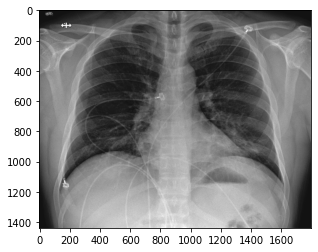

In [12]:
plt.imshow(sample["img"][0], cmap="gray");

In [13]:
# full details about the image is available in the pandas csv
d.csv.iloc[0]

index                                                                     0
patientid                                                                 2
offset                                                                  0.0
sex                                                                       M
age                                                                    65.0
finding                                            Pneumonia/Viral/COVID-19
RT_PCR_positive                                                           Y
survival                                                                  Y
intubated                                                                 N
intubation_present                                                        N
went_icu                                                                  N
in_icu                                                                    N
needed_supplemental_O2                                                    Y
extubated   

In [14]:
import pandas as pd
pd.Series(dict(zip(d.pathologies,sample["lab"])))

Aspergillosis     0.0
Aspiration        0.0
Bacterial         0.0
COVID-19          1.0
Chlamydophila     0.0
Fungal            0.0
H1N1              0.0
Herpes            0.0
Influenza         0.0
Klebsiella        0.0
Legionella        0.0
Lipoid            0.0
MERS-CoV          0.0
MRSA              0.0
Mycoplasma        0.0
No Finding        0.0
Nocardia          0.0
Pneumocystis      0.0
Pneumonia         1.0
SARS              0.0
Staphylococcus    0.0
Streptococcus     0.0
Tuberculosis      0.0
Varicella         0.0
Viral             1.0
dtype: float32

In [16]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

In [19]:
import skimage, torch, torchvision

import torch
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
from google.colab.patches import cv2_imshow
import torchvision
import pandas as pd                     

import os
import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [17]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.csv = self.csv.drop_duplicates(subset=['filename'])
        self.all_image_names = self.csv[:]['filename']
        self.all_labels = np.array(['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila' , 'Fungal', 'H1N1', 'Herpes', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Varicella', 'Viral'])
        self.df = np.array(self.csv[['filename','finding']])
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        dictlables = {'Aspergillosis': 1, 
        'Aspiration':  2 , 
        'Bacterial':   3, 
        'COVID-19':  4, 
        'Chlamydophila': 5, 
        'Fungal' :   6, 
        'H1N1' :   7, 
        'Herpes ' :   8, 
        'Influenza' :   9 , 
        'Klebsiella' :   10, 
        'Legionella' :   11, 
        'Lipoid' :   12 , 
        'MERS-CoV'  : 13, 
        'MRSA' :   14, 
        'Mycoplasma' :   15, 
        'No Finding' :  16, 
        'Nocardia' :   17, 
        'Pneumocystis' :   18, 
        'Pneumonia' :   19, 
        'SARS' :   20, 
        'Staphylococcus' : 21, 
        'Streptococcus' :   22, 
        'Tuberculosis' :   23, 
        'Varicella' :   24, 
        'Viral' : 25,
        'E.Coli':26, 
        'Unknown': 16,
        'todo':16,
         } 
        # set the training data images and labels
        self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((227, 227)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

            ])
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])

            self.labels = list(self.df[:self.train_ratio][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.df[-self.valid_ratio:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))


            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
           
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
             # define the test transforms
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread("./covid-chestxray-dataset/images/"+self.image_names[index])
        # convert the image from BGR to RGB color format
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        
        targets = self.labels[index]

        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [20]:
train_csv = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
train_csv = train_csv[train_csv['filename'].str.contains(".nii.gz") == False]
batch_size = 32
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
train_data.all_image_names[10]
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 789
[[19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 25, 4], [19, 25, 4], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 16, 16], [19, 16, 16], [19, 6, 18], [19, 6, 18], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19,

In [25]:
import torch.optim as optim
from torchvision.models import resnet50
model=resnet50(pretrained=False)
# resnet50(pretrained=False) 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 3


In [26]:
import torch
import cv2
from tqdm import tqdm
Accuracies = []
total_steps = len(train_data)
# training function
for epoch in range(epochs):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        outputs = outputs.narrow(1,0,3)
        outputs = outputs.narrow(0,0,target.size(dim=0))
        loss = criterion(target,outputs)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
        total = target.size(0)
        _,predicted = torch.max(outputs.data, 1)
        predicted = predicted.narrow(0,0,3)
        correct = (predicted == target).sum().item()
        if (i + 1) % 5 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, epochs, i + 1, total_steps, loss.item(),
                    (1 - (loss.item()/i) ) * 100))
            Accuracies.append((correct / total) * 100)

    train_loss = train_running_loss / counter
    print(train_loss)

Training


 21%|██        | 5/24 [00:13<00:39,  2.09s/it]

Epoch [1/3], Step [5/789], Loss: 4.3583, Accuracy: -8.96%


 42%|████▏     | 10/24 [00:21<00:23,  1.66s/it]

Epoch [1/3], Step [10/789], Loss: 1.5966, Accuracy: 82.26%


 62%|██████▎   | 15/24 [00:30<00:14,  1.65s/it]

Epoch [1/3], Step [15/789], Loss: 0.4457, Accuracy: 96.82%


 83%|████████▎ | 20/24 [00:37<00:05,  1.47s/it]

Epoch [1/3], Step [20/789], Loss: 0.2995, Accuracy: 98.42%


25it [00:47,  1.88s/it]


Epoch [1/3], Step [25/789], Loss: 0.1705, Accuracy: 99.29%
2.0545582938194276
Training


 21%|██        | 5/24 [00:08<00:33,  1.75s/it]

Epoch [2/3], Step [5/789], Loss: 0.2081, Accuracy: 94.80%


 42%|████▏     | 10/24 [00:16<00:22,  1.61s/it]

Epoch [2/3], Step [10/789], Loss: 0.1071, Accuracy: 98.81%


 62%|██████▎   | 15/24 [00:24<00:13,  1.55s/it]

Epoch [2/3], Step [15/789], Loss: 0.0900, Accuracy: 99.36%


 83%|████████▎ | 20/24 [00:32<00:06,  1.55s/it]

Epoch [2/3], Step [20/789], Loss: 0.0585, Accuracy: 99.69%


25it [00:40,  1.61s/it]


Epoch [2/3], Step [25/789], Loss: 0.0501, Accuracy: 99.79%
0.1320919533073902
Training


 21%|██        | 5/24 [00:08<00:32,  1.72s/it]

Epoch [3/3], Step [5/789], Loss: 0.0530, Accuracy: 98.67%


 42%|████▏     | 10/24 [00:17<00:24,  1.77s/it]

Epoch [3/3], Step [10/789], Loss: 0.0283, Accuracy: 99.69%


 62%|██████▎   | 15/24 [00:25<00:14,  1.62s/it]

Epoch [3/3], Step [15/789], Loss: 0.0309, Accuracy: 99.78%


 83%|████████▎ | 20/24 [00:33<00:06,  1.60s/it]

Epoch [3/3], Step [20/789], Loss: 0.0205, Accuracy: 99.89%


25it [00:40,  1.61s/it]

Epoch [3/3], Step [25/789], Loss: 0.0184, Accuracy: 99.92%
0.03323492154479027


In [28]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)

            outputs = outputs.narrow(1,0,3)
            outputs = outputs.narrow(0,0,target.size(dim=0))


            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [29]:
valid_loss = []
valid_epoch_loss = validate(
    model, valid_loader, criterion, valid_data, device
)
valid_loss.append(valid_epoch_loss)
print(f'Val Loss: {valid_epoch_loss:.4f}')

Validating


5it [00:12,  2.53s/it]

Val Loss: -14.9338
